### Imports

In [ ]:
# various imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting seaborn display pattern for matplotlib
sns.set()

# sklearn for preprocessing and model evaluation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# for faster data loading
import shutil
import os

# tensorflow for model structure
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Lambda, Dense, BatchNormalization,
    Dropout, Concatenate, Activation
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Manipulating the DataFrame

In [ ]:
# load Dataframe
imageDataframe = pd.read_csv('/content/drive/MyDrive/Deep Learing Project/delivery/processed_image_data_final.csv')

# create Labelencoder and transform the 'Cancer Type' column
classEncoder = LabelEncoder()
imageDataframe['Cancer Type Encoded'] = classEncoder.fit_transform(imageDataframe['Cancer Type'])

# compute the counts for each original class
counts = imageDataframe['Cancer Type'].value_counts()

# create a DataFrame for class encodings
class_df = pd.DataFrame({
    'Decoded': classEncoder.classes_,
    'Encoded': range(len(classEncoder.classes_)),
    'Counts': [counts[label] for label in classEncoder.classes_]
})

# sort the DataFrame by the 'Encoded' column
class_df = class_df.sort_values(by='Encoded')
class_df

,Decoded,Encoded,Counts
0,Adenosis,0,444
1,Ductal Carcinoma,1,3451
2,Fibroadenoma,2,1014
3,Lobular Carcinoma,3,626
4,Mucinous Carcinoma,4,792
5,Papillary Carcinoma,5,560
6,Phyllodes Tumor,6,453
7,Tubular Adenoma,7,569


In [ ]:
# dropping the maginfication Collum
imageDataframe.drop(columns=['Benign or Malignant', 'Magnification'], inplace = True)

imageDataframe = imageDataframe[['rel_path', 'Cancer Type Encoded']]

file_paths = imageDataframe.copy()
file_paths.head(3)

,rel_path,Cancer Type Encoded
0,/tmp/SOB_B_A-14-22549AB-100-011.png,0
1,/tmp/SOB_B_A-14-22549AB-100-005.png,0
2,/tmp/SOB_B_A-14-22549AB-100-004.png,0


### Preloading the data

In [ ]:
shutil.copytree('/content/drive/MyDrive/Deep Learing Project/images_plain', '/tmp',dirs_exist_ok=True)

'/tmp'

### Building the dataflow generator

In [ ]:
# parameters
BATCH_SIZE = 128
IMG_SIZE = (256, 256)

# split the data into train, validation, and test sets
def split_dataset(filepaths_df):
    train_df, temp_df = train_test_split(
        filepaths_df,
        test_size=0.3,
        stratify=filepaths_df['Cancer Type Encoded'],
        random_state=42
    )
    test_df, val_df = train_test_split(
        temp_df,
        test_size=0.5,
        stratify=temp_df['Cancer Type Encoded'],
        random_state=42
    )
    return train_df, val_df, test_df

# validate file paths
def validate_file_paths(filepaths_df):
    invalid_paths = [path for path in filepaths_df['rel_path'] if not os.path.exists(path)]
    if invalid_paths:
        raise FileNotFoundError(f"The following files are missing: {invalid_paths}")
    return True

# custom real-time loading function
def create_dataset(filepaths_df, img_size, batch_size, augment_labels = None, is_training = True):
    file_paths = filepaths_df['rel_path'].values
    labels = filepaths_df['Cancer Type Encoded'].astype(np.int32).values

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # load image
    def load_image(file_path):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels = 3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image

    # simplified augmentation
    def augment_image(image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        return image

    # processing images
    def process_image(file_path, label):
        image = load_image(file_path)

        # universal preprocessing, rotate 90 degrees
        image = tf.image.rot90(image, tf.random.uniform(shape = [], minval = 0, maxval = 4, dtype = tf.int32))

        # conditionally augment the image, enhancing the minority classes
        if is_training and augment_labels and tf.reduce_any(tf.equal(label, augment_labels)):
            augmented_image = augment_image(image)
            return tf.data.Dataset.from_tensors((image, label)).concatenate(
                tf.data.Dataset.from_tensors((augmented_image, label))
            )
        else:
            return tf.data.Dataset.from_tensors((image, label))

    # apply processing to dataset
    dataset = dataset.flat_map(process_image)

    # shuffle training set
    # and repeat the last datapoints if the batch is too small; used to eliminate a warning that appeared repeatedly
    if is_training:
        dataset = dataset.shuffle(buffer_size = 1000).repeat()

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# compute class weights
def calculate_class_weights(train_df):
    per_class_count = train_df['Cancer Type Encoded'].value_counts()

    # multiply counts of classes other than class 1 by 2
    for label, count in per_class_count.items():
        if label != 1:
            per_class_count[label] = count * 2

    # calculate class weights
    total_samples = per_class_count.sum()
    class_weights = {}
    for label, count in per_class_count.items():
        class_weights[label] = total_samples / (len(per_class_count) * count)

    return class_weights

### Executing the creation of the datasets

In [ ]:
filepaths = file_paths.copy()

# we split the dataset
train_df, val_df, test_df = split_dataset(filepaths)

# we check that there are no missing files
validate_file_paths(train_df)
validate_file_paths(val_df)
validate_file_paths(test_df)

# define augmented labels, everything except D-Carcinoma
augment_labels = [0, 2, 3, 4, 5, 6, 7]

# create train, test, validation datasets
train_ds = create_dataset(train_df, IMG_SIZE, BATCH_SIZE, augment_labels, is_training=True)
val_ds = create_dataset(val_df, IMG_SIZE, BATCH_SIZE, augment_labels, is_training=False).repeat()
test_ds = create_dataset(test_df, IMG_SIZE, BATCH_SIZE, augment_labels, is_training=False)

# compute effective dataset size
augmented_count = train_df['Cancer Type Encoded'].isin(augment_labels).sum()
effective_train_size = len(train_df) + augmented_count

# calculate steps per epoch
steps_per_epoch = effective_train_size // BATCH_SIZE
if effective_train_size % BATCH_SIZE != 0:
    steps_per_epoch += 1

# calculate class weights
class_weights = calculate_class_weights(train_df)

print("Class Weights")
print(class_weights)

print("\nSteps_per_epoch")
print(steps_per_epoch)

Class Weights
{1: 0.4478476821192053, 2: 0.7619718309859155, 4: 0.9765342960288809, 3: 1.235159817351598, 7: 1.3592964824120604, 5: 1.3801020408163265, 6: 1.7066246056782335, 0: 1.7395498392282958}

Steps_per_epoch
68


### Defining callbacks

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 7,
    mode = 'auto',
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6
)

### Creating the model

In [ ]:
# the base model is a pretrained DenseNet121
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape = (256, 256, 3)
)

# unfreeze all the layers
base_model.trainable = True

# find the last convolutional layer...
for layer in base_model.layers:
    if layer.name == 'conv5_block16_concat':
        x = layer.output
        break

# and change the rest of the model to combat overfitting
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# flatten and normalize
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(x)

# final layers
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(8, activation='softmax')(x)

# creating the model
model = Model(inputs=base_model.input, outputs=predictions)

# compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,103,880 (27.10 MB)

 Trainable params: 7,020,104 (26.78 MB)

 Non-trainable params: 83,776 (327.25 KB)

### Fitting the model

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 70,
    verbose = 1,

    # we use the calculations made above
    class_weight = class_weights,

    steps_per_epoch = steps_per_epoch,
    validation_steps = len(val_df) // BATCH_SIZE,
    callbacks = [earlystopping, reduce_lr]
)

Epoch 1/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.3311 - loss: 1.7486 - val_accuracy: 0.1545 - val_loss: 2.0348 - learning_rate: 1.0000e-04
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6854 - loss: 0.7826 - val_accuracy: 0.2059 - val_loss: 1.9667 - learning_rate: 1.0000e-04
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7998 - loss: 0.4853 - val_accuracy: 0.3126 - val_loss: 1.8743 - learning_rate: 1.0000e-04
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8752 - loss: 0.3126 - val_accuracy: 0.6232 - val_loss: 1.5492 - learning_rate: 1.0000e-04
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9032 - loss: 0.2366 - val_accuracy: 0.7554 - val_loss: 1.2003 - learning_rate: 1.0000e-04
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9372 - loss: 0.1652 - val_accuracy: 0.7951 - val_loss: 0.8437 - learning_rate: 1.0000e-04
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9490 

### Comparing the training and validation

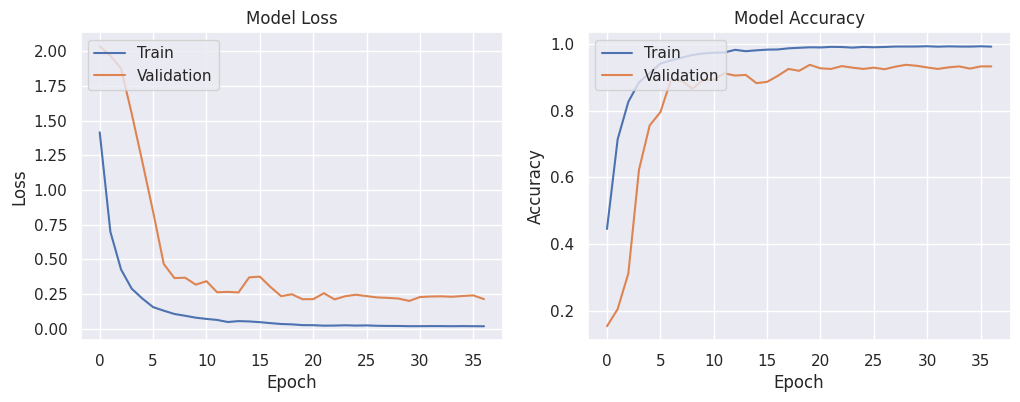

In [ ]:
# plotting the validation and the training loss and accuracy in two plots, side by side
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

### Testing the model

10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
Test Accuracy: 0.9443507588532883
Test F1 Score: 0.9366925477221837
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.97      0.95      0.96       517
           2       0.96      0.94      0.95       152
           3       0.76      0.89      0.82        94
           4       0.97      0.94      0.95       119
           5       0.95      0.96      0.96        84
           6       0.90      0.93      0.91        68
           7       0.95      0.98      0.97        85

    accuracy                           0.94      1186
   macro avg       0.93      0.94      0.94      1186
weighted avg       0.95      0.94      0.95      1186



/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


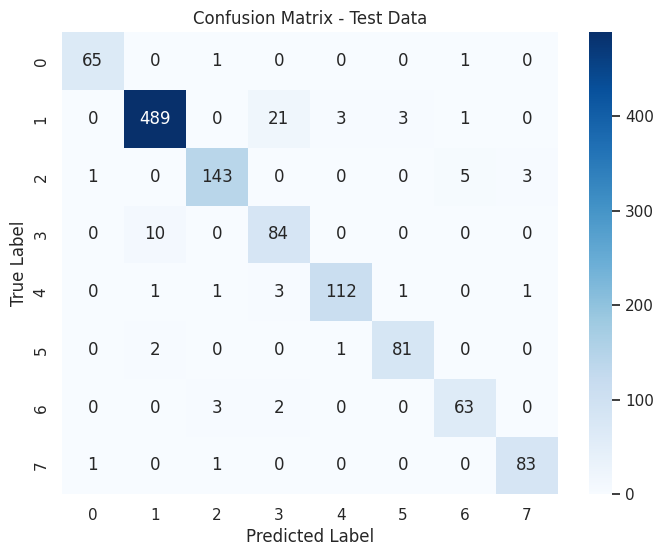

In [ ]:
# get true labels from the test dataset
y_test_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
test_predictions = model.predict(test_ds)

# predicting on the test dataset and rounding the results
y_test_pred = np.argmax(test_predictions, axis=1)

# print the F1 score, accuracy, and classification report
test_f1 = f1_score(y_test_true, y_test_pred, average='macro')
test_accuracy = np.mean(y_test_true == y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print(classification_report(y_test_true, y_test_pred))

# compute and display the confusion matrix
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt = 'd', cmap = 'Blues', xticklabels = np.unique(y_test_true), yticklabels = np.unique(y_test_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Data")
plt.show()